# Historic Soil Moisture in the East River Valley
------------------------------------------------------
### Daniel Hogan - University of Washington

This notebook takes one through a variety of resources for soil moisture specifically within the East River valley.
Data sources include:
- Snotel data from Butte (2003), Park Cone (2003), and Schofield Pass (2012) obtained from the NRCS
- MERRA-2 model output available from 1980-2022 at https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/data_access/
- ERA-5 model output from Climate Copernicus from (1980-2022) at https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview
- CBRFC upper Colorado modeled output from their operational model from (missing 2015 and 2016) 1980-2022 https://www.cbrfc.noaa.gov/rmap/grid800/index_soil.php?type=soilfall&area=cbrfc&area=uc
- Soil moisture from a RMBL study from 2011-2016 (missing 2013) carbone_rmbl_2011_2015_SM.csv

### First, we'll import necessary packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
from datetime import datetime
from datetime import date
import datetime as dt

import os
import json
import cfgrib
import xarray as xr
import gzip

import requests

### General Code needed throughout

In [63]:
kp_coords = [38.94182, -106.97298]

# OBSERVED DATA
---------------------------
---------------------------

# SNOTEL Data (1)
----------------------------------------------
### Gets monthly soil temperature and soil moisture data from these three site names using the files listed from the NRCS

In [59]:
# Gets monthly soil temperature and soil moisture data from these three site names using the files listed
files = [
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/STO/CO/Schofield%20Pass.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/SMS/CO/Schofield%20Pass.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/STO/CO/Park%20Cone.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/SMS/CO/Park%20Cone.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/STO/CO/Butte.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/SMS/CO/Butte.csv",
]

site_names = ["Schofield Pass", "Park Cone", "Butte"]
elements = ["STO", "SMS"]
ersoilsdict = {}
counter = 0
for i, site in enumerate(site_names):
    try:
        ersoilsdict[site] = {elements[0]:pd.read_csv(files[counter]), elements[1]:pd.read_csv(files[counter+1])}
        counter+=2
    except: 
        ersoilsdict[site] = {elements[0]:pd.read_csv(files[counter]), elements[1]:None}
        counter+=2



# SNOTEL Data (2)
------------------------------------

### Another function is used to grab the SNOTEL data from sites around the East River valley
- A script is used to grab the data using an API.
- This API pulls relevant SNOTEL data from the desired locations (20-inch moisture specifically). 
- Now I will organize each site into a single dataframe
- The API pull provides 50 cm temperature and soil moisture

In [ ]:
er_sntl_ds = xr.open_dataset('../../../../../../storage/dlhogan/sos/data/east_river_sntl_20220930.nc')
er_sntl_ds = er_sntl_ds.where(er_sntl_ds['SMS']<=100, np.nan)

In [ ]:
# Still need to do some data cleaning here and create a continuous dataset
monthly_mean_sm_butte = er_sntl_ds.isel(Location=0)['SMS'].resample(Date='M').median()
monthly_mean_sm_parkcone = er_sntl_ds.isel(Location=1)['SMS'].resample(Date='M').median()
monthly_mean_sm_schofield_pass = er_sntl_ds.isel(Location=2)['SMS'].resample(Date='M').median()

norm_sm_butte = (monthly_mean_sm_butte - monthly_mean_sm_butte.mean())/monthly_mean_sm_butte.std()
norm_sm_parkcone = (monthly_mean_sm_parkcone - monthly_mean_sm_parkcone.mean())/monthly_mean_sm_parkcone.std()
norm_sm_schofield_pass = (monthly_mean_sm_schofield_pass - monthly_mean_sm_schofield_pass.mean())/monthly_mean_sm_schofield_pass.std()

# SNOTEL Data (3)
-------------------------------
- a compiled csv with the soil moisture data from around Crested Butte area
- filters to monthly mean and normalizes the data

In [71]:
# Pull in all soil moisture data from around crested butte area
cb_sntl_df = pd.read_csv('../../data/crested_butte_snotel.csv', comment='#')
cb_sntl_df['Date'] = pd.to_datetime(cb_sntl_df['Date'])
cb_sntl_df = cb_sntl_df.set_index('Date')

In [72]:
# Filter data
cols = ['Butte (380) Soil Moisture Percent -2in (pct) Start of Day Values',
	       'Butte (380) Soil Moisture Percent -8in (pct) Start of Day Values',
           'Butte (380) Soil Moisture Percent -20in (pct) Start of Day Values',
           'Park Cone (680) Soil Moisture Percent -2in (pct) Start of Day Values',
           'Park Cone (680) Soil Moisture Percent -8in (pct) Start of Day Values',
           'Park Cone (680) Soil Moisture Percent -20in (pct) Start of Day Values',
           'Schofield Pass (737) Soil Moisture Percent -2in (pct) Start of Day Values',
           'Schofield Pass (737) Soil Moisture Percent -8in (pct) Start of Day Values',
           'Schofield Pass (737) Soil Moisture Percent -20in (pct) Start of Day Values',]
cb_sntl_df.loc[cb_sntl_df.index.year == 2003,cols[0:3]] = np.nan # throw out 2003 data at Butte (very poor quality)
cb_sntl_df_filtered = cb_sntl_df[(cb_sntl_df[cols] <= 100) & # throw out data over 100%
                                 (np.abs(cb_sntl_df[cols].diff()) < 20)][cols] # throw out data where the daily difference is > 20%

# Get monthly values and normalize
cb_sntl_df_monthly_sm = cb_sntl_df_filtered[cols].groupby(pd.Grouper(freq='M')).mean()
norm_cb_sntl_df_monthly_sm = (cb_sntl_df_monthly_sm - cb_sntl_df_monthly_sm.mean())/cb_sntl_df_monthly_sm.std()


# RMBL Data - East River VWC 
------------------------------
- depths available are 5 cm, 15 cm and 50 cm from 2012 to 2016 but missing 2013

<AxesSubplot: >

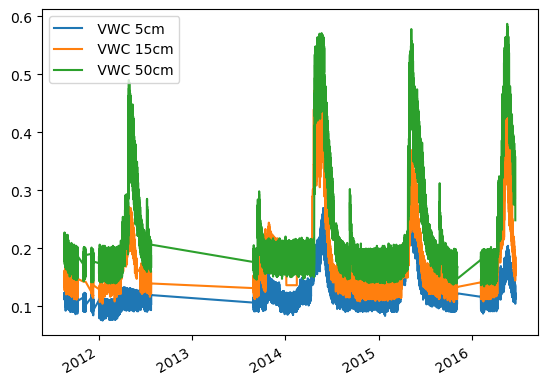

In [65]:
# pull in RMBL soil moisture data
rmbl_sm_df = pd.read_csv("../../data/carbone_rmbl_2011_2015_SM.csv", sep='\t')
# only take columns I want
rmbl_sm_df = rmbl_sm_df[['Year',' Month', ' Day', ' Hour', ' VWC 5cm',' VWC 15cm',' VWC 50cm']].dropna()

# use this to replace index with a datetime index
years = [yr.replace('.0','') for yr in rmbl_sm_df.Year.astype(str)]
months = [mo.replace('.0','') for mo in rmbl_sm_df[' Month'].astype(str)]
for i,mo in enumerate(months):
    if int(mo) < 10:
        months[i] = '0'+mo
days = [dy.replace('.0','') for dy in rmbl_sm_df[' Day'].astype(str)]
for i,day in enumerate(days):
    if int(day) < 10:
        days[i] = '0'+day
hours = [hr.replace('.0','') for hr in rmbl_sm_df[' Hour'].astype(str)]
for i,hr in enumerate(hours):
    if int(hr) < 10:
        hours[i] = '0'+hr

dates = []
for i in range(len(years)):
    d = years[i] + months[i] + days[i] +' '+ hours[i]
    dates.append(datetime.strptime(d,'%Y%m%d %H'))
rmbl_sm_df.index = dates

# visualize rmbl soil moisture data to make sure this worked
rmbl_sm_df[[' VWC 5cm',' VWC 15cm', ' VWC 50cm']].plot()

### Get monthly RMBL data and normalize the data for later comparison

In [66]:
monthly_rmbl_sm_df=rmbl_sm_df[[' VWC 5cm',' VWC 15cm', ' VWC 50cm']].groupby(pd.Grouper(freq='M')).mean()
norm_monthly_rmbl_sm_df = ((monthly_rmbl_sm_df - monthly_rmbl_sm_df.mean())/monthly_rmbl_sm_df.std())

# MODELED DATA 
-----------------------------
-----------------------------

# ERA-5 Model Output (1980-2022)
-------------------------------------
### ERA-5 soil moisture is now pulled in. Script is available to pull this data.

In [60]:
# pull in desired ERA5 data for soil moisture
era51821 = xr.open_mfdataset("../../../../../../storage/dlhogan/sos/data/ERA5/annual_data/*.grib", engine="cfgrib")

skipping variable: paramId==182 shortName='e'
Traceback (most recent call last):
  File "/home/dlhogan/.conda/envs/sos_env1/lib/python3.9/site-packages/cfgrib/dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/dlhogan/.conda/envs/sos_env1/lib/python3.9/site-packages/cfgrib/dataset.py", line 607, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1072915200, 1075593600, 1078099200, 1080777600, 1083369600,
       1086048000, 1088640000, 1091318400, 1093996800, 1096588800,
       1099267200, 1101859200, 1104537600, 1107216000, 1109635200,
       1112313600, 1114905600, 1117584000, 1120176000, 1122854400,
       1125532800, 1128124800, 1130803200, 1133395200, 1136073600,
       1138752000, 1141171200, 1143849600, 1146441600, 1149120000,
       1151712000, 1154390400, 1157068800, 1159660800, 1162339200,
       11649

In [64]:
# Get the nearest grid cell and normalize
era5_er_sm = era51821.sel(latitude=kp_coords[0], longitude=kp_coords[1], method='nearest')['swvl1'].resample(time='M').mean()
norm_era5_er_sm = ((era5_er_sm - era5_er_sm.mean())/era5_er_sm.std()).to_dataframe()

# MERRA-2 Model Output (1980-2022)
------------------------------------
- MERRA-2 Model Output
- The first set of variables are ground wetness values (GWET*) in (dimensionless) units of relative saturation for different layer depths (more on that below). A value of 1 indicates a completely saturated soil, and a value of 0 indicates a completely water-free soil
- Here we use GWETPROF product which is the full profile wetness down to bedrock
- IOverall, the soil moisture variables are provided for three nested layers, the profile (PR) layer from the surface down to the bedrock, the 0-100 cm root zone (RZ) layer, and the 0-5 cm topmost or surface (SF) layer.

- The layer depth associated with PRMC (and GWETPROF) is dzpr.

In [67]:
ds = xr.open_mfdataset('../../../../../../storage/dlhogan/sos/data/merra_2/*.nc4', engine='netcdf4')

merra2_er_sm = ds.sel(lat=kp_coords[0], lon=kp_coords[1], method='nearest')['GWETPROF'].resample(time='M').mean()
norm_merra2_er_sm = ((merra2_er_sm - merra2_er_sm.mean())/merra2_er_sm.std()).to_dataframe()

# CBRFC Modeled Output (1980-2022)
-----------------------------------
- Missing 2015 and 2016
- Grab CBRFC data and from concatenated netcdf

In [68]:
cbrfc_ds = xr.open_dataset('../../../../../../storage/dlhogan/sos/data/cbrfc_fall_soil_product.nc')

In [84]:
# Filter out data and grab nearest grid cell to KP
kp_cbrfc_sm = cbrfc_ds.sel(lat=kp_coords[0], lon=kp_coords[1], method='nearest')['soil_moisture']
kp_cbrfc_sm = kp_cbrfc_sm.where(kp_cbrfc_sm>0, np.nan)
norm_kp_cbrfc_sm = (kp_cbrfc_sm - kp_cbrfc_sm.mean())/kp_cbrfc_sm.std()

# Starting to investigate signals between these annual products
- SNOTEL
- MERRA-2
- ERA5

First, let us look at normalized soil moisture signals across our different measurements and model output

Text(0.5, 1.0, 'Monthly Mean SNOTEL/ERA-5/MERRA-2 Soil Moisture')

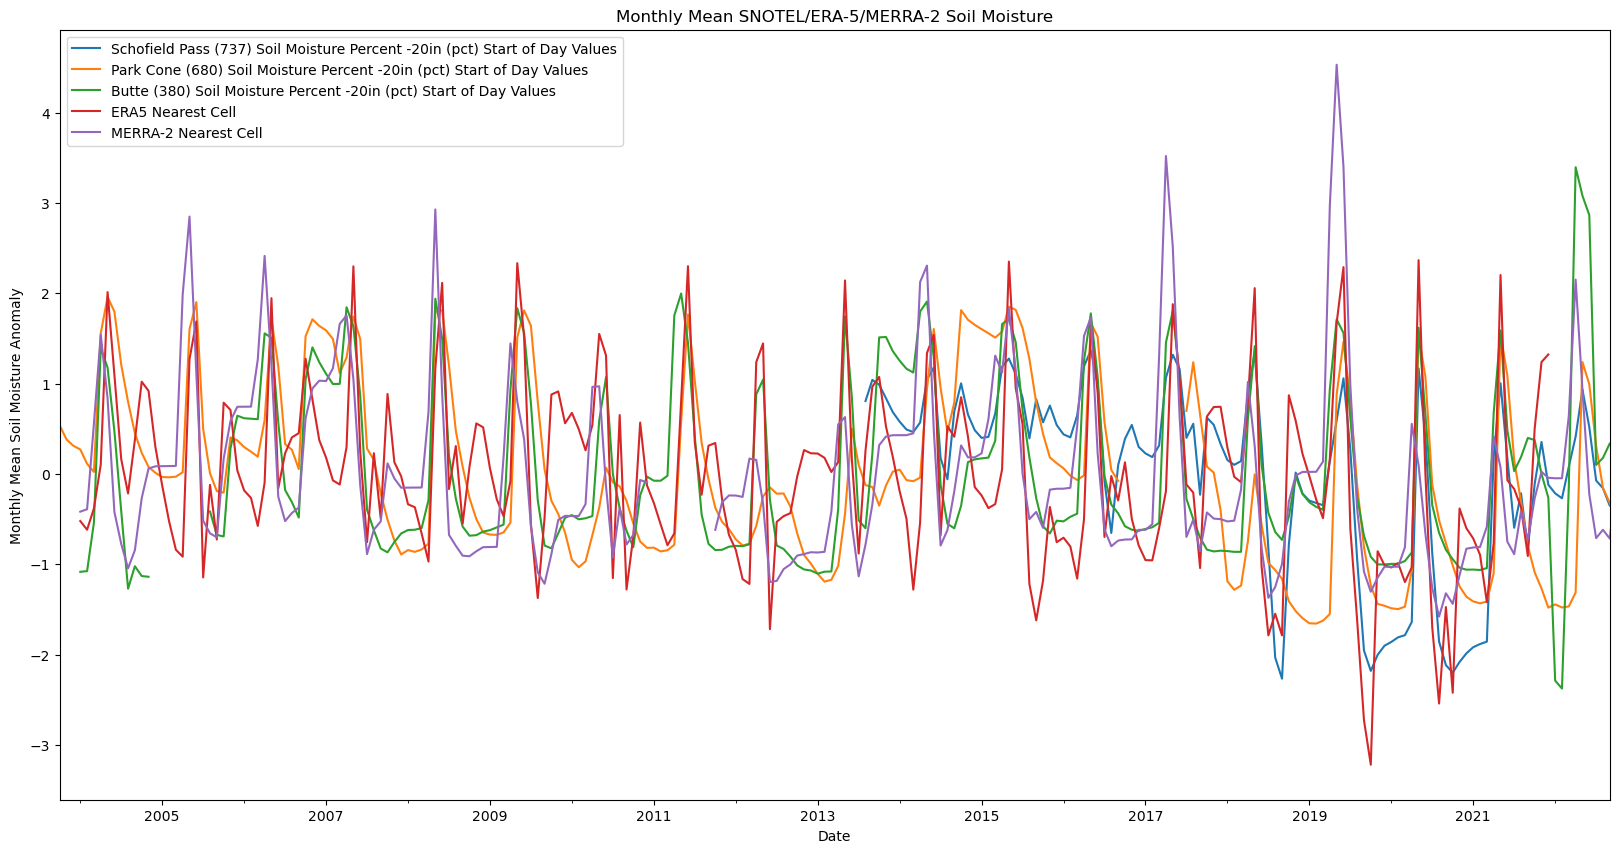

In [73]:
fig, ax = plt.subplots(figsize=(20,10))

norm_cb_sntl_df_monthly_sm[cols[::-3]].plot(ax=ax, )
norm_era5_er_sm['swvl1'].plot(ax=ax, label='ERA5 Nearest Cell')
norm_merra2_er_sm['GWETPROF'].plot(ax=ax, label='MERRA-2 Nearest Cell')
ax.set_xlim(date(2003,10,1),date(2022,9,30))
ax.set_ylabel('Monthly Mean Soil Moisture Anomaly')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Monthly Mean SNOTEL/ERA-5/MERRA-2 Soil Moisture')

Overall, they do track each other generally well, but lets get into some more specifics with some correlation plots

In [74]:
corr_df = pd.concat([norm_merra2_er_sm['GWETPROF'],
                norm_era5_er_sm['swvl1'],
                norm_monthly_rmbl_sm_df[' VWC 15cm'].interpolate(method='linear'),
                norm_cb_sntl_df_monthly_sm[cols[2]].interpolate(method='linear'),
                norm_cb_sntl_df_monthly_sm[cols[5]].interpolate(method='linear'),
                norm_cb_sntl_df_monthly_sm[cols[8]].interpolate(method='linear')],
                axis=1, 
                )
corr_df = corr_df.rename(columns=dict(zip(corr_df.columns,['merra2','era5','er_15cm','butte','parkcone','schofieldpass']))).dropna()

Here, I'll make a plot with the Pearson correlation coefficient, histograms and linreg plots showing one standard deviation

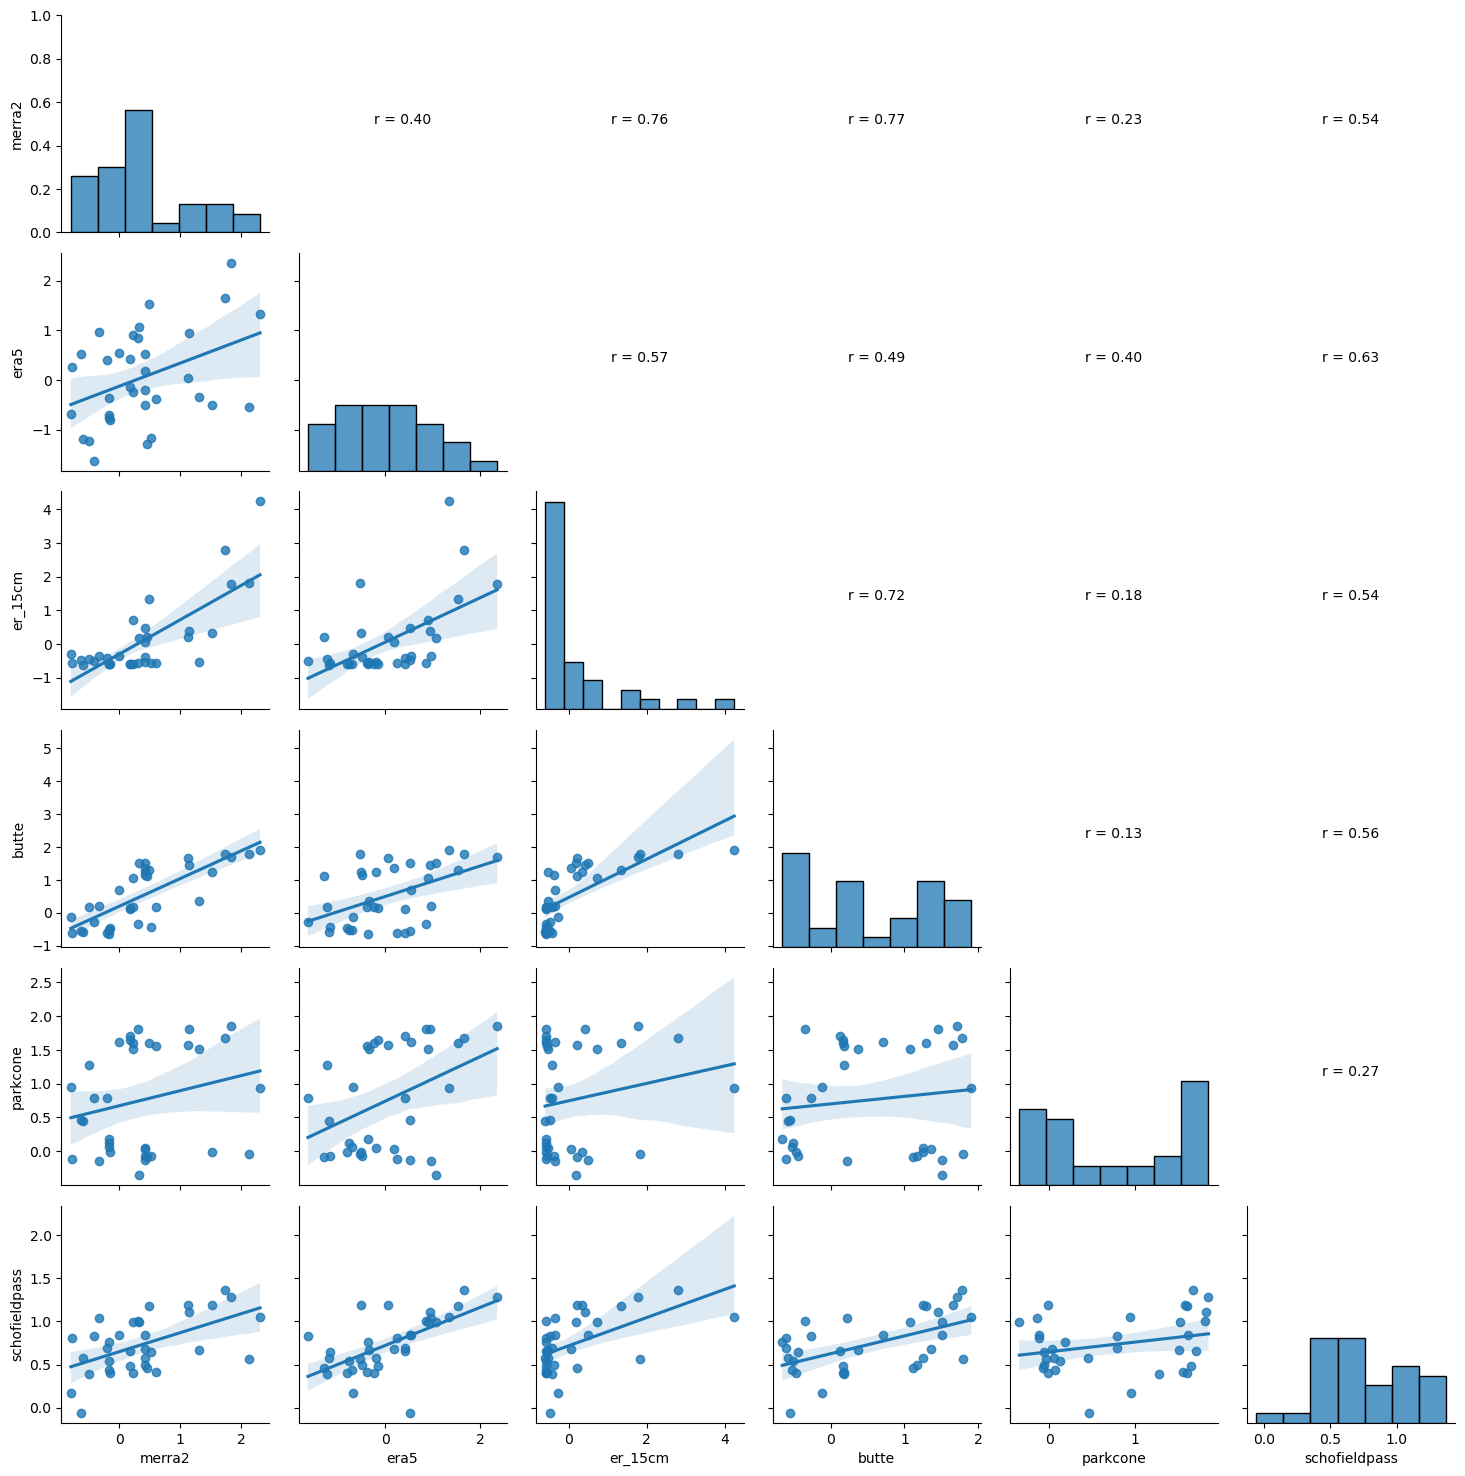

In [77]:
# can use this to try and get a pearson coefficient 
# https://stackoverflow.com/questions/59326121/add-regression-line-in-the-scatter-matrix-of-pandas
import seaborn as sns
from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

g = sns.PairGrid(corr_df)
g.map_diag(sns.histplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)

Now I'll print out the correlation table for a closer look

In [78]:
corr_df.corr()

,merra2,era5,er_15cm,butte,parkcone,schofieldpass
merra2,1.000000,0.402307,0.758068,0.769471,0.232092,0.543748
era5,0.402307,1.000000,0.567629,0.490723,0.397359,0.631695
er_15cm,0.758068,0.567629,1.000000,0.716656,0.180579,0.543964
butte,0.769471,0.490723,0.716656,1.000000,0.126817,0.557562
parkcone,0.232092,0.397359,0.180579,0.126817,1.000000,0.267093
schofieldpass,0.543748,0.631695,0.543964,0.557562,0.267093,1.000000


# Signals of Fall Soil Moisture
--------------------------------
### Looking at Fall Soil Moisture ONLY

First, I'll filter out non-fall data (calling fall Augest-October due to snowfall) fro the MERRA-2, ERA-5 and SNOTEL data

In [79]:
# mean fall MERRA-2
fall_mean_sm_merra2 = merra2_er_sm.where(merra2_er_sm.time.dt.month.isin([8,9,10])).resample(time='Y').mean()
norm_fall_mean_sm_merra2 = ((fall_mean_sm_merra2-fall_mean_sm_merra2.mean())/fall_mean_sm_merra2.std()).to_dataframe()


# mean fall ERA5
fall_mean_sm_era5 = era5_er_sm.where(era5_er_sm.time.dt.month.isin([8,9,10])).resample(time='Y').mean()
norm_fall_mean_sm_era5 = ((fall_mean_sm_era5-fall_mean_sm_era5.mean())/fall_mean_sm_era5.std()).to_dataframe()

# mean fall SNTL
fall_mean_sm_sntl = cb_sntl_df_monthly_sm.loc[cb_sntl_df_monthly_sm.index.month.isin([8,9,10])]
fall_mean_sm_sntl = fall_mean_sm_sntl.groupby(fall_mean_sm_sntl.index.year).mean()

norm_fall_mean_sm_sntl = (fall_mean_sm_sntl-fall_mean_sm_sntl.mean())/fall_mean_sm_sntl.std()
norm_fall_mean_sm_sntl.index = pd.to_datetime([str(year)+'1231' for year in norm_fall_mean_sm_sntl.index], format='%Y%m%d')

In [ ]:
# Convert cbrfc data to pandas and add a datetime index for the CBRFC data
norm_kp_cbrfc_sm = norm_kp_cbrfc_sm.to_dataframe()
norm_kp_cbrfc_sm.index = pd.to_datetime([str(year)+'1231' for year in norm_kp_cbrfc_sm.index], format='%Y%m%d')

# Fall Soil Moisture Data and Product Comparison

Text(0.5, 1.0, 'Fall Soil Moisture Anomaly')

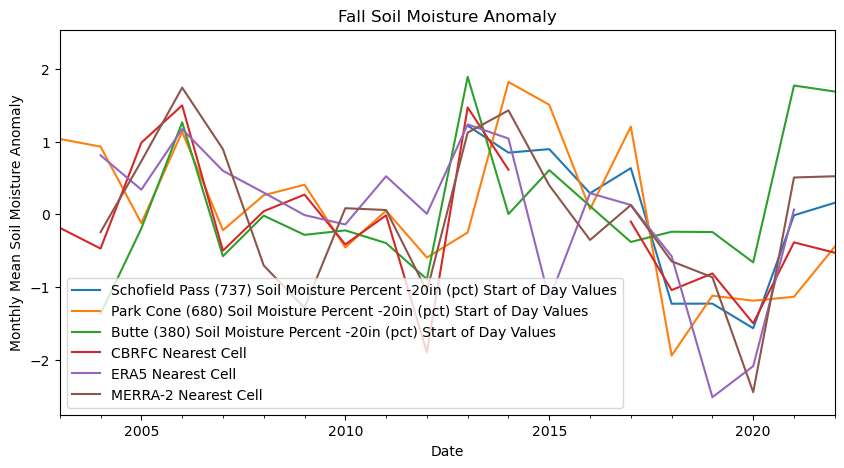

In [87]:
fig, ax = plt.subplots(figsize=(10,5))

norm_fall_mean_sm_sntl[cols[::-3]].plot(ax=ax, )
norm_kp_cbrfc_sm['soil_moisture'].plot(ax=ax, label='CBRFC Nearest Cell')
norm_fall_mean_sm_era5['swvl1'].plot(ax=ax, label='ERA5 Nearest Cell')
norm_fall_mean_sm_merra2['GWETPROF'].plot(ax=ax, label='MERRA-2 Nearest Cell')
ax.set_xlim(date(2003,10,1),date(2022,9,30))
ax.set_ylabel('Monthly Mean Soil Moisture Anomaly')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Fall Soil Moisture Anomaly')

### Let's do another correlation table but exclude Schofield Pass for a longer time series

In [95]:
corr_df = pd.concat([norm_fall_mean_sm_merra2['GWETPROF'],
                norm_fall_mean_sm_era5['swvl1'],
                norm_kp_cbrfc_sm['soil_moisture'],
                norm_fall_mean_sm_sntl[cols[2]],
                norm_fall_mean_sm_sntl[cols[5]],
                norm_fall_mean_sm_sntl[cols[8]]],
                axis=1, 
                )
corr_df = corr_df.rename(columns=dict(zip(corr_df.columns,['merra2','era5','cbrfc','butte','parkcone','schofield'])))

In [96]:
corr_df.corr()

,merra2,era5,cbrfc,butte,parkcone,schofield
merra2,1.000000,0.679237,0.719692,0.538361,0.471192,0.862036
era5,0.679237,1.000000,0.645479,0.240751,0.469975,0.769225
cbrfc,0.719692,0.645479,1.000000,0.540660,0.570394,0.912822
butte,0.538361,0.240751,0.540660,1.000000,0.068579,0.513957
parkcone,0.471192,0.469975,0.570394,0.068579,1.000000,0.775108
schofield,0.862036,0.769225,0.912822,0.513957,0.775108,1.000000


<Figure size 1000x600 with 0 Axes>

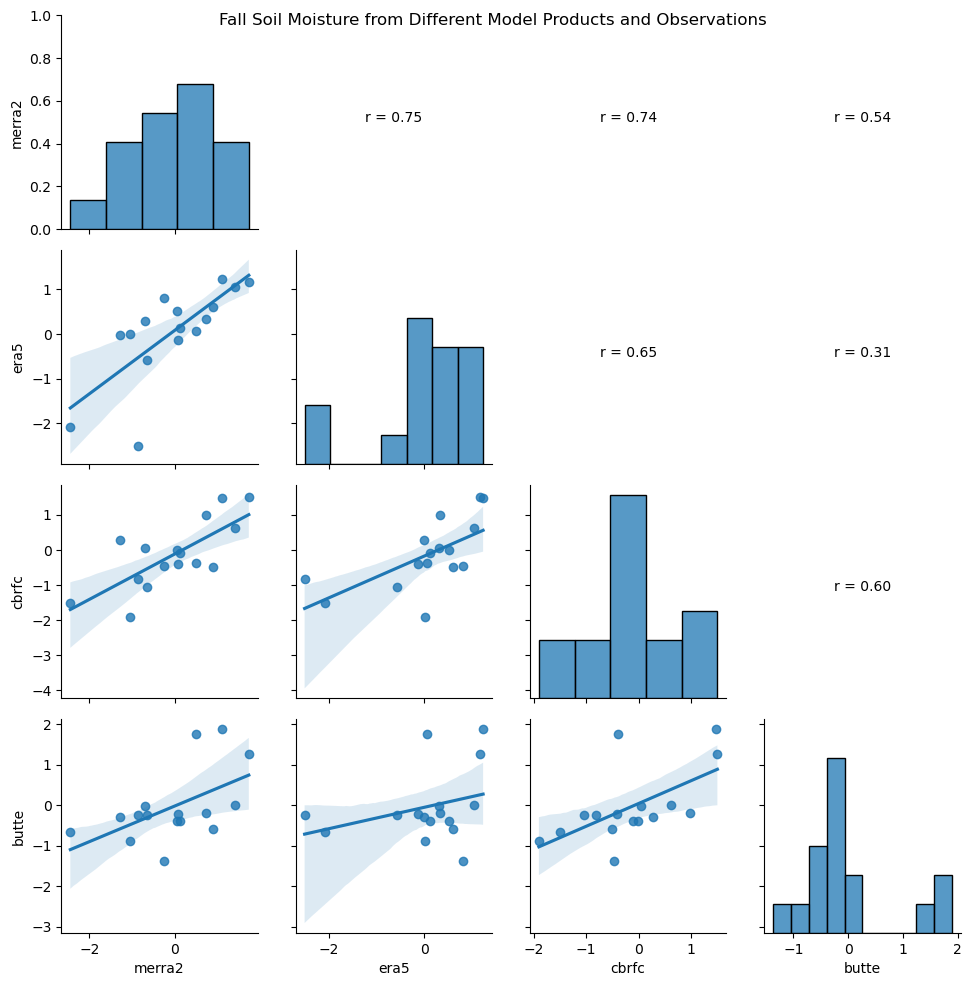

<Figure size 1000x600 with 0 Axes>

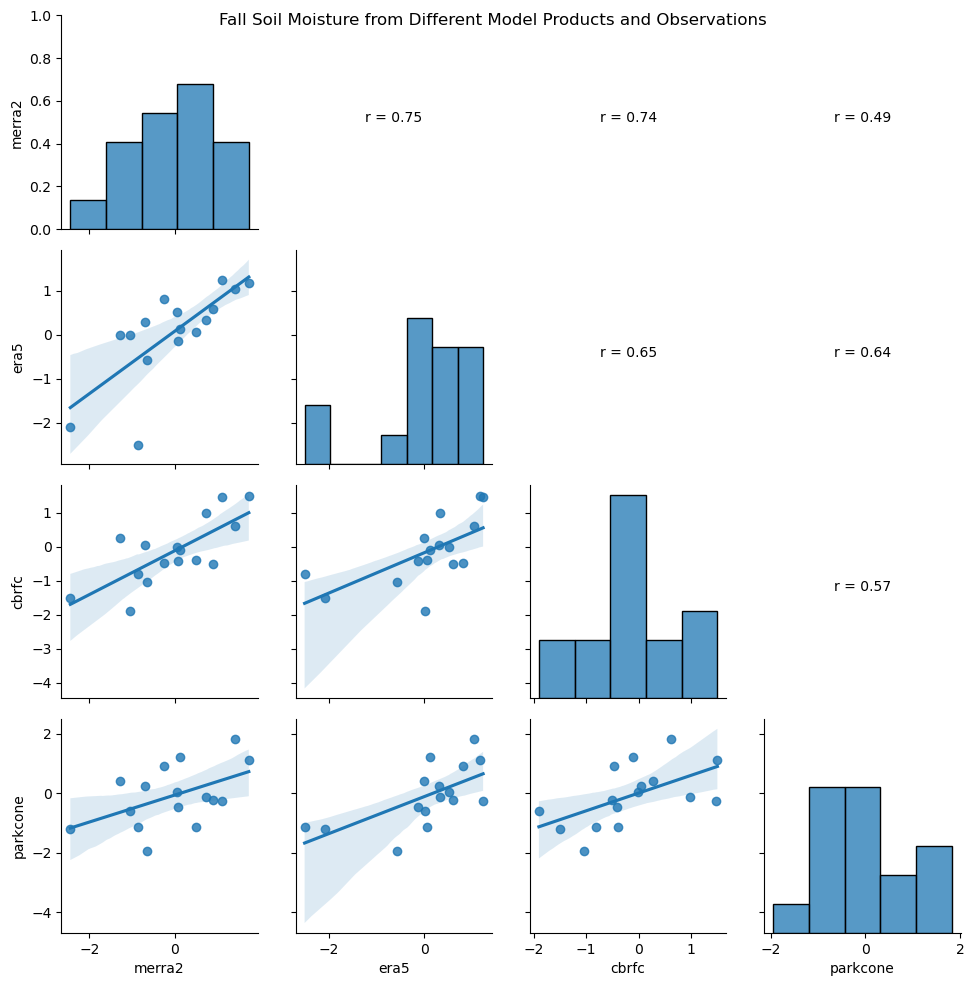

<Figure size 1000x600 with 0 Axes>

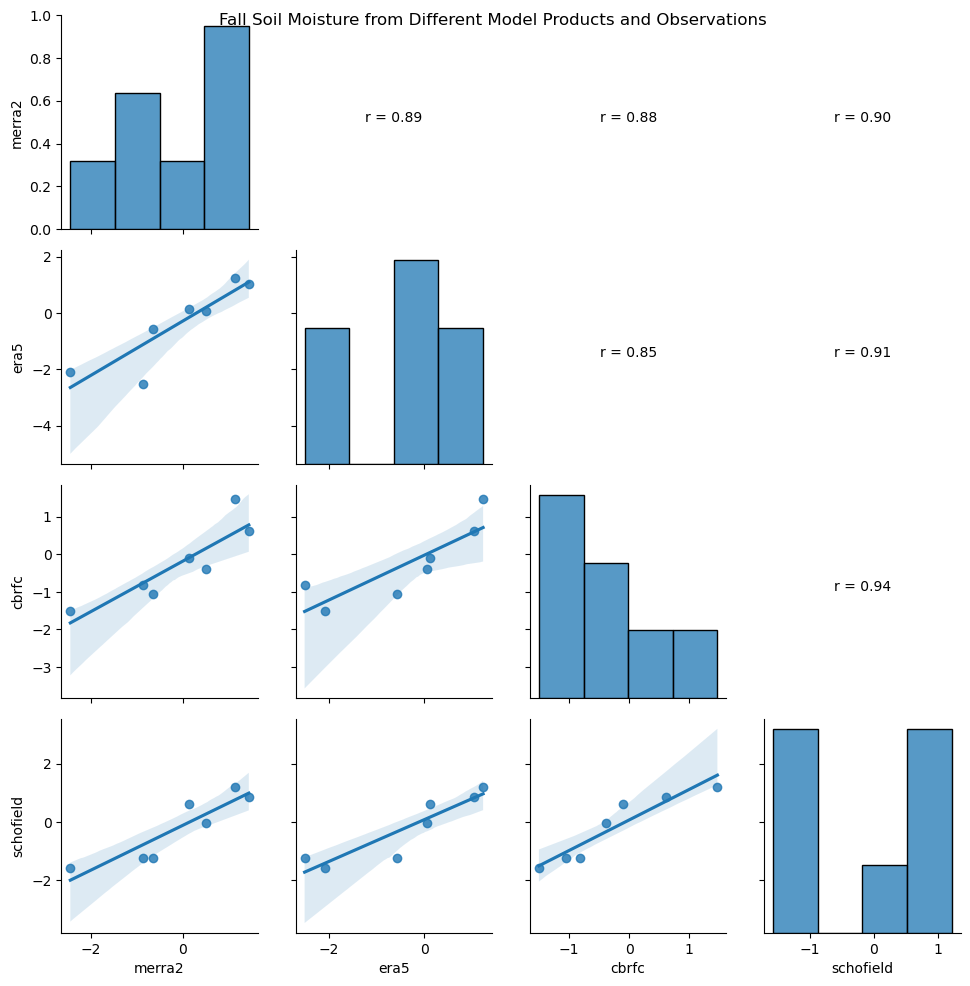

<Figure size 1000x600 with 0 Axes>

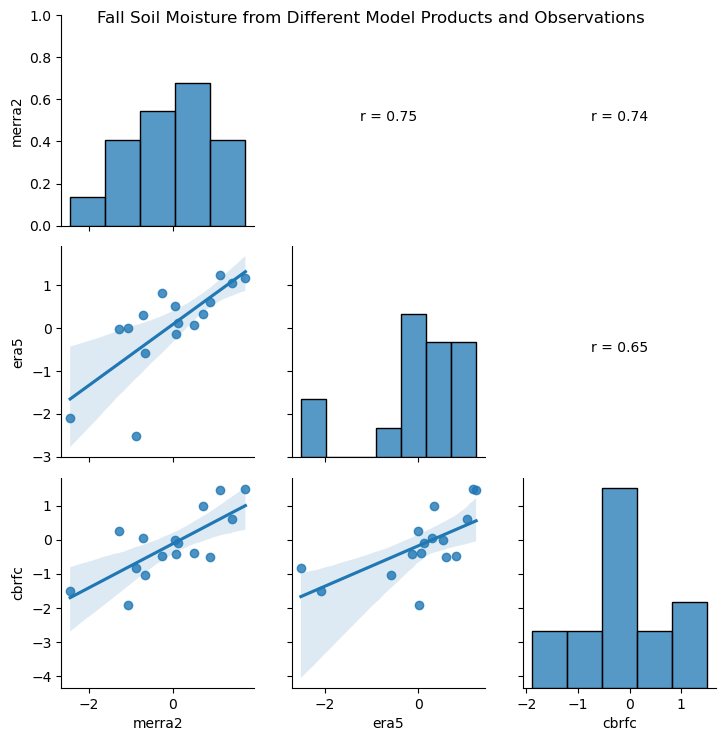

In [102]:
# can use this to try and get a pearson coefficient 
# https://stackoverflow.com/questions/59326121/add-regression-line-in-the-scatter-matrix-of-pandas
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()


sntlidx = [2,5,8,0]
name = ['butte','parkcone','schofield']
for i,idx in enumerate(sntlidx):
    if idx==0:
        corr_df = pd.concat([norm_fall_mean_sm_merra2['GWETPROF'],
                        norm_fall_mean_sm_era5['swvl1'],
                        norm_kp_cbrfc_sm['soil_moisture']],
                        axis=1, 
                        )
        corr_df = corr_df.rename(columns=dict(zip(corr_df.columns,['merra2','era5','cbrfc'])))
    else:
        corr_df = pd.concat([norm_fall_mean_sm_merra2['GWETPROF'],
                        norm_fall_mean_sm_era5['swvl1'],
                        norm_kp_cbrfc_sm['soil_moisture'],
                        norm_fall_mean_sm_sntl[cols[idx]]],
                        axis=1, 
                        )
        corr_df = corr_df.rename(columns=dict(zip(corr_df.columns,['merra2','era5','cbrfc',name[i]])))
    
    plt.figure(figsize=(10,6))
    g = sns.PairGrid(corr_df.dropna())
    g.map_diag(sns.histplot)
    g.map_lower(sns.regplot)
    g.map_upper(reg_coef)
    g.fig.suptitle('Fall Soil Moisture from Different Model Products and Observations')

# Conclusions from the Fall analysis: 
----------------------------------------------------------------
Synopsis:

CBRFC>MERRA-2>ERA5

MERRA-2: The soil moisture product of choice when compared to the available regional snotel sites is MERRA-2. Across the board, it shows the strongest relationships between all 3 sites across both annual and fall soil moisture when compared to ERA-5

CBRFC: The CBRFC model does a better job for Butte and Schofield and slightly worse than ERA-5 for Park Cone. It is a substantially smaller grid cell (8km vs. around 24 km for the other products), so this may help it, but it is not a measureable value, but the signals are worthy of note. CBRFC and MERRA-2 also agree the best with each other.

ERA-5: ERA-5 performed the worst when directly comparing to the values at Schofield and Butte, but better at Park Cone.

In all, I think using the MERRA-2 product for proxy soil moisture may be best since I can get a physical value from it and then use that to create annual water balances going back to 1980.

